# Developing and visualising metrics

## Imports

In [4]:

import os
import numpy as np
import matplotlib.pyplot as plt
import sys 
import json
import random
from scipy.stats import spearmanr
from collections import defaultdict
import asyncio
import nest_asyncio
nest_asyncio.apply()
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../src')))

import pubmetric.network as nw
import pubmetric.pckg_dev as dev
import pubmetric.metrics as met

In [5]:
path_to_data = '../out_20240801231111' 
loaded_graph = asyncio.run(nw.create_citation_network(inpath=path_to_data, load_graph=True))

2024-08-06 14:59:19 - Graph loaded from ../out_20240801231111


# Rated workflows dataset 

## Load dataset

In [7]:
# LOAD files 

# with open('test_rated.json', 'r') as json_file:
#     test_set = json.load(json_file)

# print(len(test_set))
# print(test_set[0]) # one workflow

with open('../data/train_rated.json', 'r') as json_file:
    train_set = json.load(json_file)

print(len(train_set))
print(train_set[0]) # one workflow



250
{'ratingAvg': 0.5, 'expert1': 0.0, 'expert2': 1.0, 'workflow': [['msConvert', 'Comet'], ['Comet', 'ProteinProphet'], ['ProteinProphet', 'PeptideProphet']], 'pmid_workflow': [['23051804', '23148064'], ['23148064', '14632076'], ['14632076', '12403597']], 'usecase': 2, 'scenario': 'Original ', 'id': 177, 'rating_bin': '0-1'}


In [8]:
pmid_workflows = [item['pmid_workflow'] for item in train_set]

## Parse raw dataset files

Not necessary to do twice, rather load the files above

In [6]:
metadata_filename = 'tool_metadata_topic_0121_20240703.json' # replace with your metadatafile

In [ ]:
file_paths = ['metriccomp/usecase1.xlsx', 'metriccomp/usecase2.xlsx', 'metriccomp/usecase3.xlsx', 'metriccomp/usecase4.xlsx']  # files downloaded from APE in the wild paper
tuple_data = parse_xml(file_paths, metadata_filename)

In [8]:
print(len(tuple_data))

400


In [15]:
wf_old_unique, wf_repeated, wf_all_unique = unique_workflows(tuple_data, metadata_filename)

No available pmid for ThermoRawFileParser
No available pmid for mzXMLplot
No available pmid for mzXMLplot
No available pmid for mzXMLplot
No available pmid for mzXMLplot
No available pmid for mzXMLplot
No available pmid for mzXMLplot
No available pmid for mzXMLplot


In [16]:
print(len(wf_all_unique))

313


In [17]:
train_set, test_set = stratified_split(wf_all_unique)
print(len(train_set))

250


## Expert rated data stats

In [9]:
expert_ratings = [workflow['ratingAvg'] for workflow in train_set]

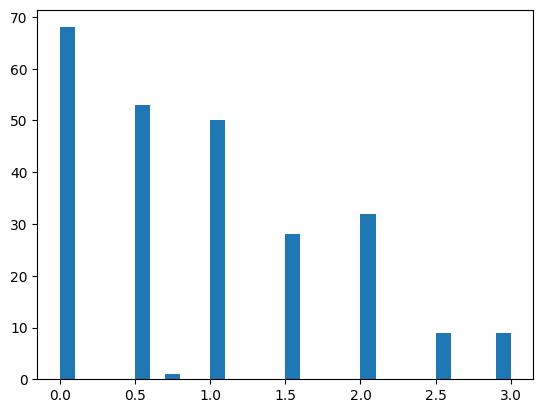

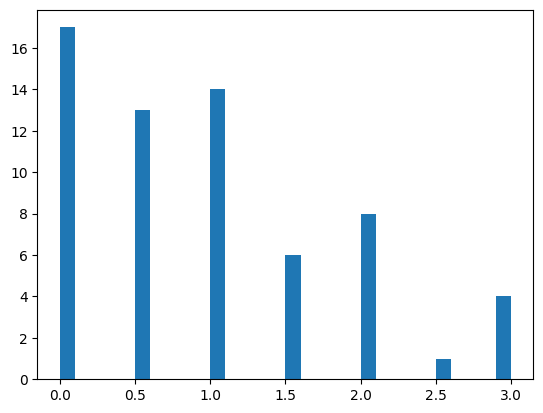

In [10]:
train_ratings = expert_ratings
test_ratings = [ item['ratingAvg'] for item in test_set]

plt.hist(train_ratings, bins =30)
plt.show()
plt.hist(test_ratings, bins =30)
plt.show()

In [20]:
pmid_workflows = [item['pmid_workflow'] for item in train_set]
print(len(pmid_workflows))

250


180


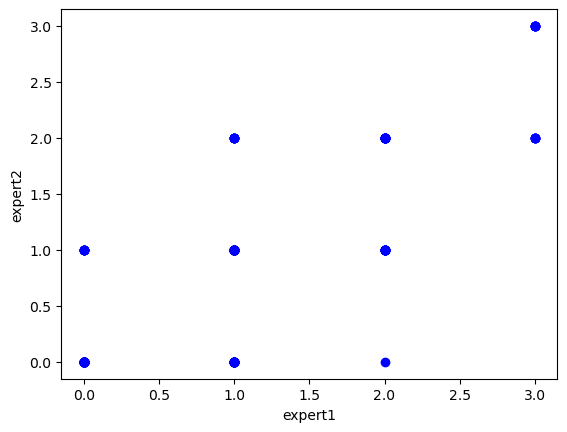

In [12]:
expert1_ratings = [workflow['expert1'] for workflow in train_set if 'expert1' in workflow]
expert2_ratings = [workflow['expert2'] for workflow in train_set if 'expert2' in workflow]
print(len(expert1_ratings))
plt.scatter(expert1_ratings, expert2_ratings, color='blue')

plt.xlabel('expert1')
plt.ylabel('expert2')
plt.show()



Spearman's correlation coefficient: 0.7573767122994546
P-value: 8.851091495323676e-35
Expert 1 mean 1.0333333333333334 and median 1.0
Expert 2 mean 0.8166666666666667 and median 1.0


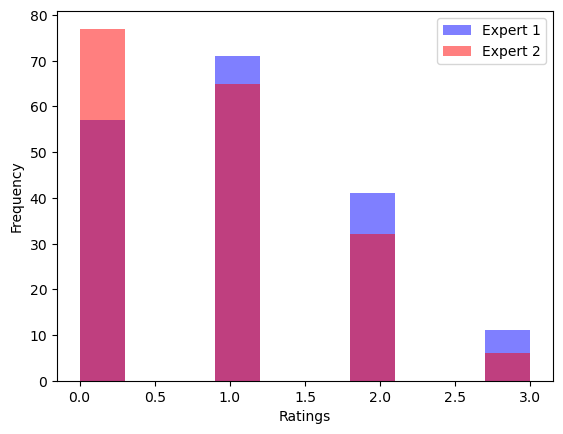

In [13]:
# Spearman's correlation coefficient
correlation, p_value = spearmanr(expert1_ratings, expert2_ratings)

print(f"Spearman's correlation coefficient: {correlation}")
print(f"P-value: {p_value}")
print("Expert 1 mean", np.mean(expert1_ratings), "and median", np.median(expert1_ratings))
print("Expert 2 mean", np.mean(expert2_ratings), "and median", np.median(expert2_ratings))

plt.hist(expert1_ratings, bins=10, alpha=0.5, color='blue', label='Expert 1')
plt.hist(expert2_ratings, bins=10, alpha=0.5, color='red', label='Expert 2')
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

49


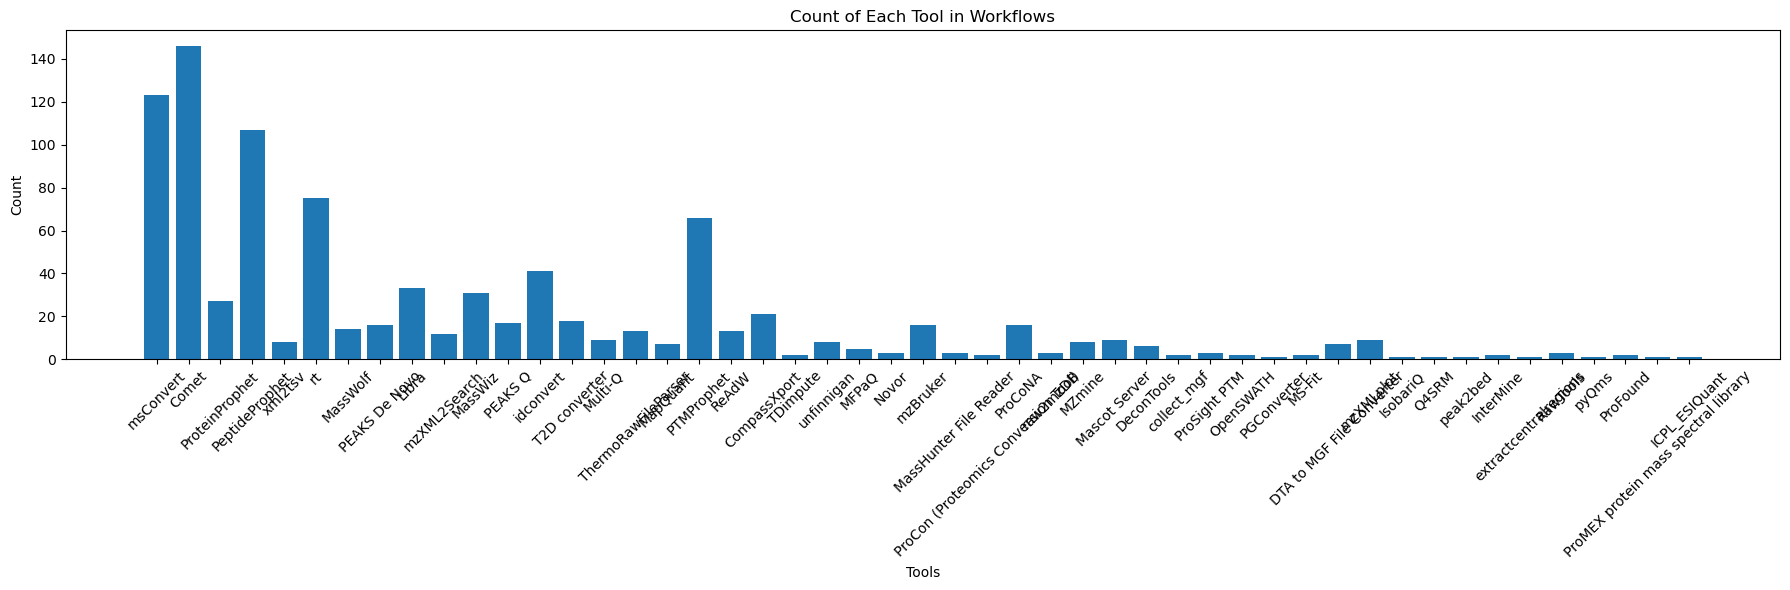

In [17]:
# Function to count tools
def count_tools(workflows):
    tool_counts = defaultdict(int)
    for workflow in workflows:
        seen_tools = set()
        for step in workflow:
            tool1, tool2 = step
            if tool1 not in seen_tools:
                tool_counts[tool1] += 1
                seen_tools.add(tool1)
            if tool2 not in seen_tools:
                tool_counts[tool2] += 1
                seen_tools.add(tool2)
        seen_tools.clear()  # Clear set for next workflow
    return tool_counts

# Count tools
tool_counts = count_tools([wf['workflow'] for wf in train_set])
print(len(tool_counts))
# Plotting the counts in a bar plot
plt.figure(figsize=(18, 6))
plt.bar(tool_counts.keys(), tool_counts.values())
plt.xlabel('Tools')
plt.ylabel('Count')
plt.title('Count of Each Tool in Workflows')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# why is it wonky?

Only 49 tools in total in the training part (80 % or 250 workflows) of the manually rated dataset. This is compared to the about 1800 tools in the proteomics domain in bio.tools. msconvert and comet, are present in more than 50% of the workflows meaning a metric will be biased towards them if developed in this dataset. 

## Running metrics

In [ ]:
example_workflow_names = [  ('msConvert', 'Comet'),   
                            ('Comet', 'PTMProphet')]

example_workflow_pmids = [  ('23051804', '23148064'),
                            ('23148064', '25631240')]

example_workflow_tools = ['23051804', '23148064', '25631240']

In [98]:
workflow_average_score = []
degree_workflow_average_score = []
log_worfklow_average_score = []
workflow_product_score = []
log_workflow_product_score = []
connectivity_score = []
workflow_weighted_connectivity_score = []
age_workflow_average_score = []
age_connectivity_score = []
min_connectivity_score = []
citations_connectivity_score = []
min_connectivity_score = []
citations_connectivity_score = []
citation_scores = []
random_scores = []

random.seed(42)


for workflow in pmid_workflows:
    workflow_average_score.append(met.workflow_average_sum(graph=loaded_graph, workflow=workflow))
    degree_workflow_average_score.append(met.degree_workflow_average_sum(graph=loaded_graph, workflow=workflow))
    log_worfklow_average_score.append(met.log_workflow_edge_product(graph=loaded_graph, workflow=workflow))
    workflow_product_score.append(met.workflow_edge_product(graph=loaded_graph, workflow=workflow))
    log_workflow_product_score.append(met.log_workflow_edge_product(graph=loaded_graph, workflow=workflow))
    connectivity_score.append(met.connectivity(graph=loaded_graph, workflow=workflow))
    workflow_weighted_connectivity_score.append(met.workflow_weighted_connectivity(graph=loaded_graph, workflow=workflow))
    age_workflow_average_score.append(met.age_workflow_average_sum(graph=loaded_graph, workflow=workflow))
    age_connectivity_score.append(met.age_connectivity(graph=loaded_graph, workflow=workflow))
    min_connectivity_score.append(met.min_connectivity(loaded_graph, workflow))
    citations_connectivity_score.append(met.citation_connectivity(loaded_graph, workflow))
    citation_scores.append(met.median_citations(loaded_graph, workflow))
    random_scores.append(random.randrange(0,6))


### "Evaluating" metrics

In [116]:
# Metrics and their names
metrics = [
    workflow_average_score, degree_workflow_average_score, log_worfklow_average_score, workflow_product_score, log_workflow_product_score, connectivity_score,
    workflow_weighted_connectivity_score, age_workflow_average_score, age_connectivity_score, min_connectivity_score, citations_connectivity_score, min_connectivity_score, citations_connectivity_score,
    citation_scores, random_scores
]


metric_names = [
    'Workflow Average Score', 'Degree Workflow Average Score', 'Log Workflow Average Score',
    'Workflow Product Score', 'Log Workflow Product Score', 'Connectivity Score',
    'Workflow Weighted Connectivity Score', 'Age Workflow Average Score', 'Age Connectivity Score',
    'Min Connectivity Score', 'Citations Connectivity Score', 'Min Scores', 
    'Citation Normalised Scores', 'Citation Scores', 'Random Scores'
]

correlations = []

for metric in metrics:
    correlation, p_value = spearmanr(expert_ratings, metric)
    correlations.append( (round(correlation, 4), p_value) )


In [118]:

half = len(expert_ratings) // 2

correlations = []
for metric in metrics:
    full_correlation, full_p_value = spearmanr(expert_ratings, metric)
    
    first_half_correlation, first_half_p_value = spearmanr(expert_ratings[:half], metric[:half])
    second_half_correlation, second_half_p_value = spearmanr(expert_ratings[half:], metric[half:])
    
    # Variation score (difference in correlations between the two halves)
    variation_score = first_half_correlation - second_half_correlation
    
    correlations.append({
        'full': (round(full_correlation, 4), full_p_value),
        'first_half': (round(first_half_correlation, 4), first_half_p_value),
        'second_half': (round(second_half_correlation, 4), second_half_p_value),
        'variation_score': round(variation_score, 4)
    })

for idx, corr in enumerate(correlations):
    print(f"Metric {idx+1}:")
    print(f"  Full data: Correlation = {corr['full'][0]}, p-value = {corr['full'][1]:.1E}")
    print(f"  First half: Correlation = {corr['first_half'][0]}, p-value = {corr['first_half'][1]:.1E}")
    print(f"  Second half: Correlation = {corr['second_half'][0]}, p-value = {corr['second_half'][1]:.1E}")
    print(f"  Variation score: {corr['variation_score']}")


Metric 1:
  Full data: Correlation = 0.3219, p-value = 2.0E-07
  First half: Correlation = 0.3242, p-value = 2.3E-04
  Second half: Correlation = 0.3219, p-value = 2.5E-04
  Variation score: 0.0023
Metric 2:
  Full data: Correlation = 0.3125, p-value = 4.6E-07
  First half: Correlation = 0.3169, p-value = 3.2E-04
  Second half: Correlation = 0.3098, p-value = 4.4E-04
  Variation score: 0.0071
Metric 3:
  Full data: Correlation = 0.2517, p-value = 5.7E-05
  First half: Correlation = 0.2503, p-value = 4.9E-03
  Second half: Correlation = 0.2581, p-value = 3.7E-03
  Variation score: -0.0078
Metric 4:
  Full data: Correlation = 0.2513, p-value = 5.9E-05
  First half: Correlation = 0.2405, p-value = 6.9E-03
  Second half: Correlation = 0.2618, p-value = 3.2E-03
  Variation score: -0.0213
Metric 5:
  Full data: Correlation = 0.2517, p-value = 5.7E-05
  First half: Correlation = 0.2503, p-value = 4.9E-03
  Second half: Correlation = 0.2581, p-value = 3.7E-03
  Variation score: -0.0078
Metric 

#### Scatter - metric scores against expert scores

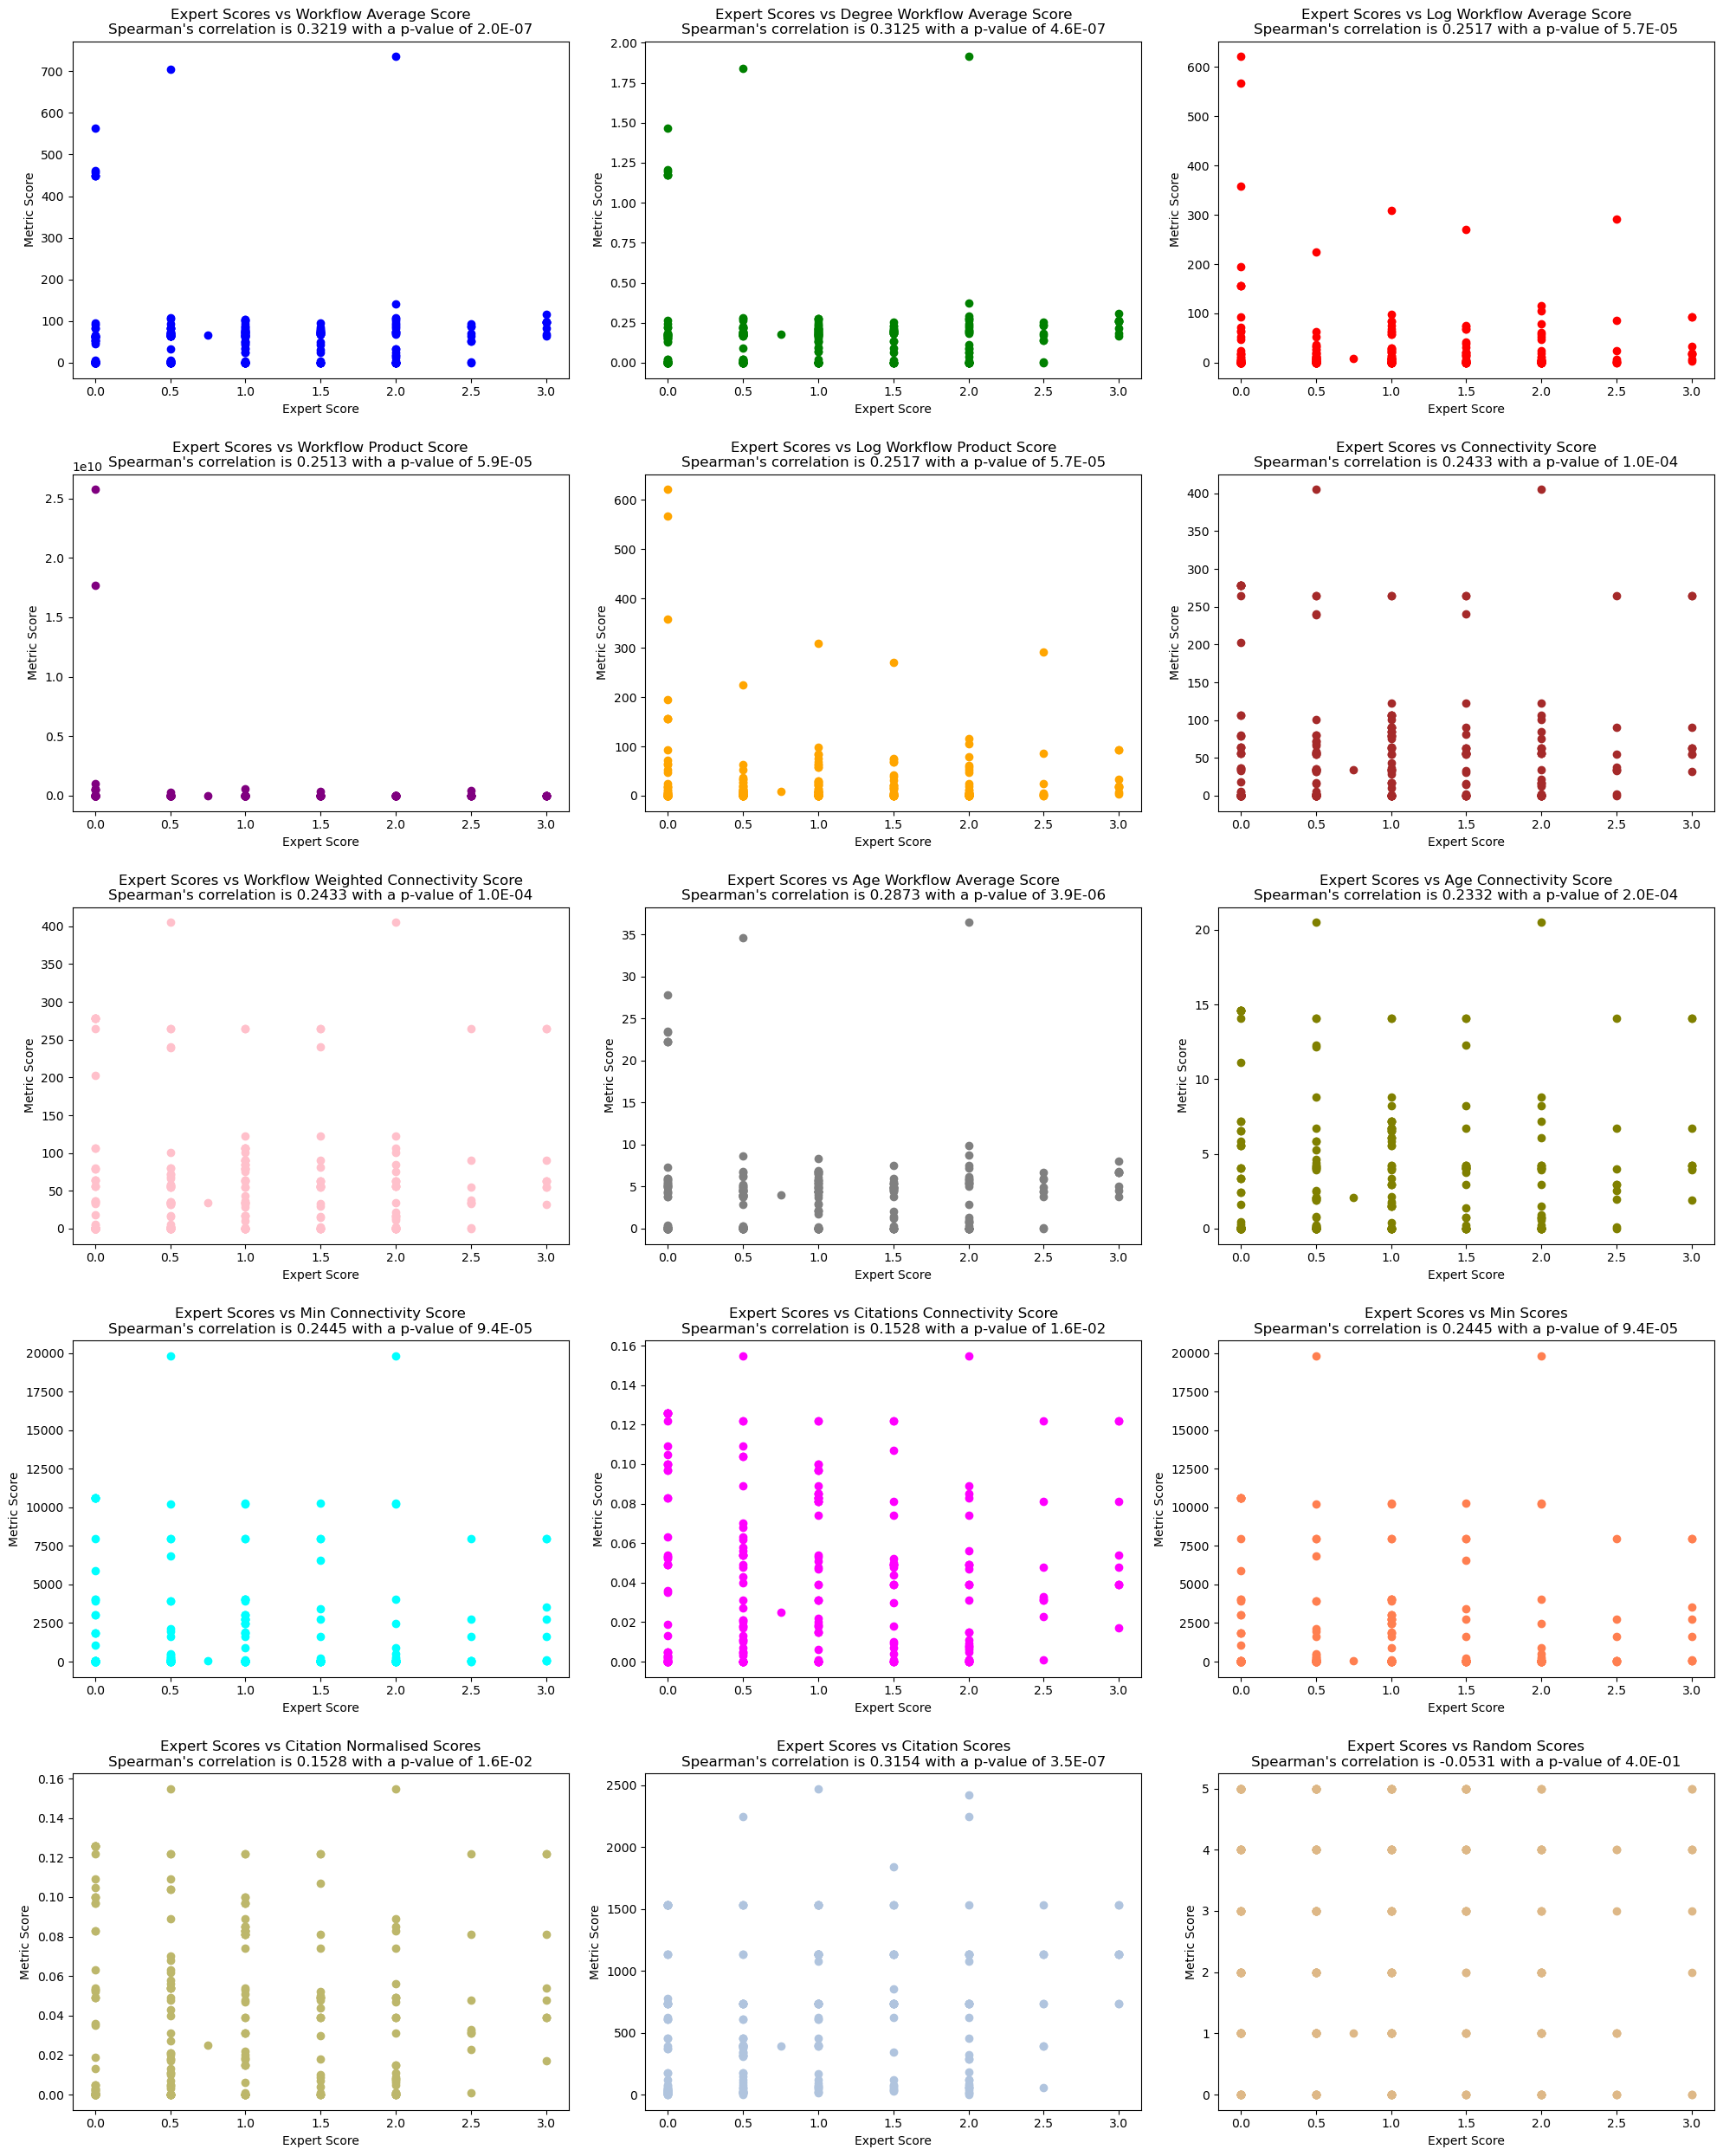

In [114]:
colours = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'grey', 'olive', 'cyan', 'magenta', 'coral', 'darkkhaki', 'lightsteelblue','burlywood']

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20, 25))
axes = axes.flatten()

for idx, (metric, name, colour, correlation) in enumerate(zip(metrics, metric_names, colours, correlations)):
    axes[idx].scatter(expert_ratings, metric, color=colour)
    axes[idx].set_title(f'Expert Scores vs {name}\nSpearman\'s correlation is {correlation[0]} with a p-value of ' + "{:.1E}".format(correlation[1]))
    axes[idx].set_xlabel('Expert Score')
    axes[idx].set_ylabel('Metric Score')

# Hide any unused subplots
for ax in axes[len(metrics):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()


##### Testing on a fake network to illustrate how they work 

In [ ]:
### Testing metrics on example tree
# The network

# Define the nodes 
tools = ['TA', 'TB', 'TC', 'TD', # connected cluster - included in final graph 
        # Separate cluster - included in final graph 
         'TE', 'TF',
        # Single disconnected cited - not included in final graph 
         'TG', 
        # Single disconnected not cited - not included in final graph 
         'TH']

citations = ['CA', 'CB', 'CC', 'CD', 'CE', 'CF', 'CG', 'CH', 'CI', 'CJ', 'CK', 'CL', 'CM', 'CN', 'CO', 'CP', 'CQ']


edges = [

    # Single citations of tools
    ('CA', 'TA'), ('CB', 'TB'), ('CC', 'TC'), ('CD', 'TD'), 
    ('CE', 'TE'), ('CF', 'TF'), ('CG', 'TG'),

    # Citations to multiple tools
    ('CJ', 'TA'), ('CJ', 'TB'),  
    ('CK', 'TA'), ('CK', 'TB'), ('CK', 'TC'),
    ('CL', 'TA'), ('CL', 'TB'), ('CL', 'TC'), ('CL', 'TD'), 
    
    # Duplicate edges
    ('CP', 'TE'), ('CP', 'TE'),

    # Tools citing each other
    ('TB', 'TC'), 

    # Tools citing themselves
    ('TA', 'TA'),

    # Disconnected cluster
    ('CQ', 'TE'), ('CQ', 'TF'), ('CO', 'TE'),
    ('CO', 'TF') 
]

nodes_in_final_network = ['TA', 'TB', 'TC', 'TD', 'TE', 'TF', 'CJ', 'CK', 'CL', 'CO', 'CQ' ]
tools_in_final_network = ['TA', 'TB', 'TC', 'TD', 'TE', 'TF']


testgraph = igraph.Graph.TupleList(edges, directed=True)
incuded_tools = [tool for tool in testgraph.vs['pmid'] if tool in tools] #could do interrsection    
test_coG = nw.create_cocitation_graph(testgraph,incuded_tools)

layout = test_coG.layout("fr")

# Create plot
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the graph
igraph.plot(
    test_coG,
    target=ax,
    layout=layout,
    vertex_size=0.3,
    vertex_color='skyblue',
    vertex_frame_color='white',
    vertex_label=test_coG.vs['pmid'],
    vertex_label_size=10,
    edge_width=[0.5 + 2 * w for w in test_coG.es['weight']],
    edge_color='gray',
    edge_label=test_coG.es['weight'],
    edge_label_size=10
)

# Display plot
plt.show()

print( testgraph.vs['pmid'])
print( test_coG.vs['pmid'])

print( test_coG.es['weight'])

expected_edge_weights = {('TA', 'TB'): 3, ('TA', 'TC'): 2, ('TA', 'TD'): 1,
('TB', 'TC'): 3, ('TB', 'TD'): 1,
('TC', 'TD'): 1, 
('TE', 'TF'): 2, 
('TE', 'TG'): None, # G not in graph
('TA', 'TE'): 0} # both nodes in graph, but no connection

def test_get_graph_edge_weight():
    for edge, expected_weight in expected_edge_weights.items():
        print(edge,expected_weight)
        weight = get_graph_edge_weight(test_coG, edge)
        print( weight == expected_weight)
test_get_graph_edge_weight()

print(connectivity(test_coG, [('TA', 'TB'), ('TA', 'TC'), ('TA', 'TD')]))